### Instructor Demo: Financial Forecasting Part II

This program executes `1000` simulations of stock price trajectory over the next `252 * 3` trading days (or 3 years of trading) for `TSLA` stock, based on a normal probability distribution of average daily returns derived from the sample mean and standard deviation. Then, the program calculates a `95%` confidence interval of stock price outcomes for `TSLA`. 

In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

### Check Available Tickers from Alpaca Markets API

In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
tradeable

[Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'ARCA',
     'id': '02b6820c-e5d5-462f-b3d0-d600919dffd7',
     'marginable': True,
     'name': 'Direxion Daily Gold Miners Bull 3X Shares of Direxion Shares ETF '
             'Trust',
     'shortable': False,
     'status': 'active',
     'symbol': 'NUGT',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': 'd174dc71-0a75-47a7-a43c-5cf9360111bf',
     'marginable': True,
     'name': 'ETF Series Solutions Trust Loncar Cancer Immunotherapy ETF',
     'shortable': False,
     'status': 'active',
     'symbol': 'CNCR',
     'tradable': True}),
 Asset({   'class': 'us_equity',
     'easy_to_borrow': False,
     'exchange': 'NASDAQ',
     'id': '07844fc5-d49c-41dd-a543-dccaf6aec65c',
     'marginable': True,
     'name': 'Co-Diagnostics, Inc. Common Stock',
     'shortable': False,
     'status': 'active',
     'symbol': 'CODX',
     't

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df['symbol'] = pd.Series([asset.symbol for asset in assets])

# Display the first 10 asset tickers
display(asset_info_df.head(10))

,symbol
0,NUGT
1,CNCR
2,CODX
3,TDOC
4,ONEM
5,CRAI
6,SPWH
7,MEXX_deprecated
8,SDPI
9,KREF


### Get 1 Year's Worth of Data via API Call and Read in as DataFrame 

In [5]:
# Set the ticker
ticker = "TSLA"

# Set timeframe to '1D'
timeframe = '1D'

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for AAPL
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.head()

TSLA                                    
                             open    high      low    close    volume
2019-11-04 00:00:00-05:00  314.80  321.94  309.260  317.425   8579754
2019-11-05 00:00:00-05:00  319.62  323.51  316.118  317.160   6308975
2019-11-06 00:00:00-05:00  318.00  326.72  314.500  326.700   7748529
2019-11-07 00:00:00-05:00  329.14  341.50  328.020  335.390  14148570
2019-11-08 00:00:00-05:00  334.50  337.46  332.500  337.120   5966814

### Drop Extraneous Columns

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)

# Use the drop function to drop extra columns
df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)

# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.head()

,close
2019-11-04,317.425
2019-11-05,317.160
2019-11-06,326.700
2019-11-07,335.390
2019-11-08,337.120


### Calculate Daily Returns

In [7]:
# Use the `pct_change` function to calculate daily returns of TSLA
daily_returns = df.pct_change()
daily_returns.head()

,close
2019-11-04,NaN
2019-11-05,-0.000835
2019-11-06,0.030079
2019-11-07,0.026599
2019-11-08,0.005158


### Calculate Value of Average Daily Returns

In [8]:
# Use the `mean` function to calculate the mean of daily returns for TSLA
avg_daily_return = daily_returns.mean()['close']
avg_daily_return

0.006724657991054272

### Calculate Value of Standard Deviation of Daily Returns

In [9]:
# Use the `std` function to calculate the standard deviation of daily returns for TSLA
std_dev_daily_return = daily_returns.std()['close']
std_dev_daily_return

0.06056369619711004

### Run the Monte Carlo Simulation and Save Results to DataFrame

In [10]:
# Set number of simulations, trading days, and get last closing price of TSLA from DataFrame
num_simulations = 1000
num_trading_days = 252 * 3
tsla_last_price = df['close'][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):

    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_tsla_prices = [tsla_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_tsla_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_tsla_prices.append(simulated_price)
    
    # Append a simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_tsla_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,...,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000,514.560000
1,504.925753,542.873389,480.074684,538.930493,460.180460,437.290756,507.847704,500.775147,548.896817,503.590895,...,477.111416,552.518286,496.318239,523.279534,513.870452,525.007499,507.376811,518.017935,492.764812,498.209081
2,534.382154,563.617061,489.981494,586.773666,443.144305,402.677015,514.544057,472.745841,558.773805,512.861654,...,460.209075,507.690810,500.335345,540.240888,525.012502,568.209438,527.641520,513.947125,498.819046,512.234548
3,530.266124,539.670014,519.260966,599.553422,454.883128,361.877996,484.195047,495.746880,656.443644,499.745037,...,497.943585,482.361158,480.883739,586.565433,507.947345,596.260595,490.156635,489.134932,519.122063,533.493522
4,585.261282,502.078108,606.915292,607.525090,454.647983,414.017622,454.847679,504.905138,618.211007,499.301510,...,496.433028,515.846353,497.791371,588.943417,512.309398,570.625232,526.750831,457.222983,579.649732,588.427716


### Plot the Multiple Simulations of Stock Price Trajectory for TSLA over the Next 3 Years (252 * 3 Trading Days)

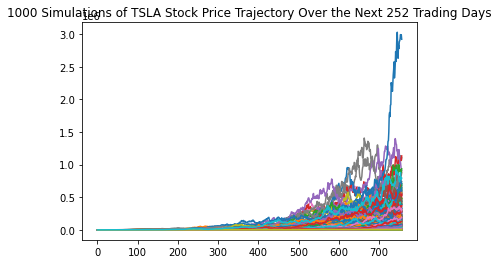

In [11]:
# Use the `plot` function to plot the trajectory of TSLA stock based on a 252 * 3 trading day simulation
plot_title = f"{n+1} Simulations of TSLA Stock Price Trajectory Over the Next 252 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title)

In [12]:
# Select the last row for project stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    12060.449643
Simulation 2     2128.728064
Simulation 3    13955.275234
Simulation 4    14714.466455
Simulation 5    12121.567071
Name: 756, dtype: float64

### Plot the Frequency Distribution of Simulated Ending Prices on the Last Simulated Trading Day

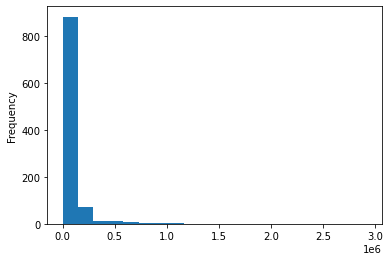

In [13]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

### View the Probability Distribution of Simulated Ending Price Ranges on the Last Simualted Trading Day

In [14]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divid the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(-2878.5440000000003, 146091.51]    0.884
(146091.51, 292140.582]             0.071
(292140.582, 438189.653]            0.014
(438189.653, 584238.725]            0.014
(584238.725, 730287.796]            0.009
(876336.868, 1022385.939]           0.003
(1022385.939, 1168435.01]           0.002
(730287.796, 876336.868]            0.002
(2774974.796, 2921023.868]          0.001
(1460533.153, 1606582.225]          0.000
(2628925.725, 2774974.796]          0.000
(1168435.01, 1314484.082]           0.000
(1606582.225, 1752631.296]          0.000
(1752631.296, 1898680.368]          0.000
(1898680.368, 2044729.439]          0.000
(2044729.439, 2190778.51]           0.000
(2190778.51, 2336827.582]           0.000
(2336827.582, 2482876.653]          0.000
(2482876.653, 2628925.725]          0.000
(1314484.082, 1460533.153]          0.000
Name: 756, dtype: float64

### Calculate Lower and Upper Bounds of 95% Confidence Interval for Simulated Ending Stock Prices of TSLA

In [15]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025       692.669134
0.975    486195.134842
Name: 756, dtype: float64

### Plot the Probability Distribution and 95% Confidence Interval of Simulated Ending Prices 

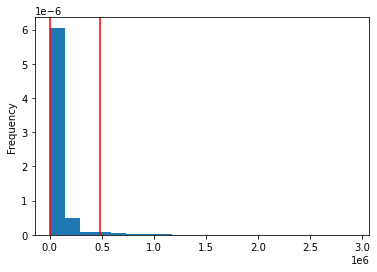

In [16]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

### Calculate 95% Confidence Interval of An Initial Investment of 10,000 in TSLA over the Next 3 Years (252 * 3) Trading Days

In [17]:
# Set initial investment
initial_investment = 10000

# Calculate cumulative profit/loss of lower and upper bound
cumulative_pnl_lower_bound = initial_investment * ((confidence_interval.iloc[0] - tsla_last_price) / tsla_last_price)
cumulative_pnl_upper_bound = initial_investment * ((confidence_interval.iloc[1] - tsla_last_price) / tsla_last_price)

# Add the initial investment to the cumulative profit/loss of lower and upper bound
ending_investment_lower_bound = initial_investment + cumulative_pnl_lower_bound
ending_investment_upper_bound = initial_investment + cumulative_pnl_upper_bound

# Print the results
print(f"There is a 95% chance that an initial investment of $10,000 in TSLA"
      f" over the next (252 * 3) trading days will end within in the range of"
      f" ${ending_investment_lower_bound} and ${ending_investment_upper_bound}")

There is a 95% chance that an initial investment of $10,000 in TSLA over the next (252 * 3) trading days will end within in the range of $13461.387085660588 and $9448754.952619806
